In [1]:
%load_ext autoreload
%autoreload 2    
%matplotlib inline

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import numpy as np
import glob
from PIL import Image, ExifTags

# pip install torchsummary
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from time import time
import pandas as pd
import random
import itertools

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset
from eval import *

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(8);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#img_size = 512

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                           )
)

In [4]:
BATCH_SIZE = 16

In [5]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)

In [6]:
loss_function = nn.BCELoss()

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = transfer_model_set(model, freeze_convs=False)
optimizer = torch.optim.Adam(model.parameters(), HEAD_LEARNING_RATE)

lr_scheduler = None

In [48]:
NUM_EPOCHS = 10

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")

    train_loss = []
    train_correct = 0
    train_len = 0
    
    for minibatch_no, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        images = [image for image, _, _ in batch]
        bboxes = [bbox for _, bbox, _ in batch]
        labels = [label for _, _, label in batch]
        
        # Selective search
                
        # Edge boxes
        cropped_images_all, proposals_all, predictions_all = edge_boxes_train(images, bboxes)         
        if len(cropped_images_all) ==0:
            print('no boxes detected')
            continue 
        data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        
        # CNN
        optimizer.zero_grad()
        output = model(data)[:,0]
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        predicted = output > 0.5
        correct_in_the_item = (target==predicted).sum().cpu().item()
        train_correct += correct_in_the_item
        train_len += data.shape[0]
        print(f'train_loss: {loss:.5f}        Accuracy {correct_in_the_item / len(target):.3f}')

        # for now we break
        
    # Test evaluation
    model.eval()
    for batch in tqdm(val_loader, total=len(val_loader)): # Keep loader at 1 
        test_images, test_bboxes, test_labels = batch[0]
        
        # Selective search

        test_cropped_images_all, test_proposals_all = edge_boxes_test(test_images, test_bboxes) 
        test_data = torch.stack(test_cropped_images_all).to(device)
        test_proposals_all = test_proposals_all[0]
        
        with torch.no_grad():
            outputs = model(test_data)[:,0]
        
        bboxes_xywh = torch.stack(test_proposals_all).to(device).to(float)
        bboxes_xyxy = copy.deepcopy(bboxes_xywh)
        bboxes_xyxy[:, 2] = bboxes_xyxy[:, 2] + bboxes_xyxy[:, 0]
        bboxes_xyxy[:, 3] = bboxes_xyxy[:, 3] + bboxes_xyxy[:, 1]
        
        
        bboxes_indices = torchvision.ops.nms(bboxes_xyxy, outputs, iou_threshold=0.1)
        
        final_bboxes = bboxes_xywh[bboxes_indices]
        
        outputs = outputs[bboxes_indices]
        
        # Reshaping
        outputs = outputs.tolist()
        
        pred = [dict(
            boxes=final_bboxes,
            scores=torch.FloatTensor(outputs).to(device),
            labels=torch.FloatTensor(np.ones(len(outputs))).to(device) # Simplification for Binary
        )]
        
        target = [dict(
            boxes=torch.FloatTensor(test_bboxes).to(device),
            labels=torch.FloatTensor(test_labels).to(device)
        ) ]
                  
        # Computing mAP
        metric = MeanAveragePrecision(box_format='xywh')
        metric.update(pred, target)
    maps = metric.compute()
    print(f'MAP: {float(maps["map"].detach().cpu()):.3f}          MAP@50: {float(maps["map_50"].detach().cpu()):.3f}          MAP_small: {float(maps["map_small"].detach().cpu()):.3f}          MAP_large: {float(maps["map_large"].detach().cpu()):.3f}')
    

EPOCH 0/10


  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.18379        Accuracy 0.934


/tmp/ipykernel_126546/1699717747.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)


train_loss: 0.26325        Accuracy 0.913
train_loss: 0.23092        Accuracy 0.908
train_loss: 0.26748        Accuracy 0.876
train_loss: 0.22533        Accuracy 0.923
train_loss: 0.32788        Accuracy 0.863
train_loss: 0.68796        Accuracy 0.750
train_loss: 0.31247        Accuracy 0.845
train_loss: 0.33843        Accuracy 0.849
train_loss: 0.28079        Accuracy 0.868
train_loss: 0.25024        Accuracy 0.898
train_loss: 0.34284        Accuracy 0.842
train_loss: 0.35100        Accuracy 0.858
train_loss: 0.40478        Accuracy 0.833
train_loss: 0.24375        Accuracy 0.909
train_loss: 0.31274        Accuracy 0.864
train_loss: 0.30149        Accuracy 0.867
train_loss: 0.33863        Accuracy 0.870
train_loss: 0.26392        Accuracy 0.904
train_loss: 0.35356        Accuracy 0.902
train_loss: 0.29243        Accuracy 0.873
train_loss: 0.19148        Accuracy 0.953
train_loss: 0.26475        Accuracy 0.886
train_loss: 0.17173        Accuracy 0.962
train_loss: 0.29440        Accurac

  0%|          | 0/300 [00:00<?, ?it/s]

MAP: 0.051          MAP@50: 0.257          MAP_small: 0.000          MAP_large: -1.000
EPOCH 1/10


  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.27610        Accuracy 0.892
train_loss: 0.25515        Accuracy 0.911
train_loss: 0.21690        Accuracy 0.921
train_loss: 0.29952        Accuracy 0.884
train_loss: 0.40245        Accuracy 0.843
train_loss: 0.26864        Accuracy 0.899
train_loss: 0.21027        Accuracy 0.914
train_loss: 0.24732        Accuracy 0.893
train_loss: 0.62658        Accuracy 0.721
train_loss: 0.33704        Accuracy 0.864
train_loss: 0.25896        Accuracy 0.868
train_loss: 0.44956        Accuracy 0.814
train_loss: 0.23688        Accuracy 0.909
train_loss: 0.21411        Accuracy 0.926
train_loss: 0.21554        Accuracy 0.928
train_loss: 0.34894        Accuracy 0.843
train_loss: 0.34688        Accuracy 0.841
train_loss: 0.32574        Accuracy 0.834
train_loss: 0.26707        Accuracy 0.885
train_loss: 0.25556        Accuracy 0.871
train_loss: 0.25851        Accuracy 0.900
train_loss: 0.35445        Accuracy 0.848
train_loss: 0.30084        Accuracy 0.888
train_loss: 0.26292        Accurac

  0%|          | 0/300 [00:00<?, ?it/s]

MAP: 0.077          MAP@50: 0.257          MAP_small: 0.000          MAP_large: -1.000
EPOCH 2/10


  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.18962        Accuracy 0.924
train_loss: 0.32485        Accuracy 0.890
train_loss: 0.29160        Accuracy 0.875
train_loss: 0.33035        Accuracy 0.880
train_loss: 0.33938        Accuracy 0.894
train_loss: 0.33975        Accuracy 0.813
train_loss: 0.29431        Accuracy 0.910
train_loss: 0.26586        Accuracy 0.912
train_loss: 0.23225        Accuracy 0.916
train_loss: 0.15938        Accuracy 0.953
train_loss: 0.20169        Accuracy 0.936
train_loss: 0.23484        Accuracy 0.917
train_loss: 0.26577        Accuracy 0.889
train_loss: 0.20426        Accuracy 0.926
train_loss: 0.22697        Accuracy 0.939
train_loss: 0.30635        Accuracy 0.866
train_loss: 0.31165        Accuracy 0.902
train_loss: 0.14826        Accuracy 0.956
train_loss: 0.29421        Accuracy 0.892
train_loss: 0.25234        Accuracy 0.910
train_loss: 0.29440        Accuracy 0.883
train_loss: 0.32832        Accuracy 0.868
train_loss: 0.25683        Accuracy 0.894
train_loss: 0.18304        Accurac

  0%|          | 0/300 [00:00<?, ?it/s]

MAP: 0.077          MAP@50: 0.257          MAP_small: 0.000          MAP_large: -1.000
EPOCH 3/10


  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.29447        Accuracy 0.898
train_loss: 0.16825        Accuracy 0.951
train_loss: 0.24495        Accuracy 0.903
train_loss: 0.19616        Accuracy 0.936
train_loss: 0.21617        Accuracy 0.956
train_loss: 0.46180        Accuracy 0.822
train_loss: 0.27624        Accuracy 0.870
train_loss: 0.20715        Accuracy 0.924
train_loss: 0.31518        Accuracy 0.906
train_loss: 0.23602        Accuracy 0.905
train_loss: 0.59302        Accuracy 0.827
train_loss: 0.30112        Accuracy 0.876
train_loss: 0.18576        Accuracy 0.920
train_loss: 0.33159        Accuracy 0.858
train_loss: 0.21720        Accuracy 0.924
train_loss: 0.25004        Accuracy 0.897
train_loss: 0.18185        Accuracy 0.939
train_loss: 0.15948        Accuracy 0.960
train_loss: 0.28210        Accuracy 0.882
train_loss: 0.25284        Accuracy 0.911
train_loss: 0.29704        Accuracy 0.874
train_loss: 0.10225        Accuracy 0.979
train_loss: 0.20128        Accuracy 0.924
train_loss: 0.38682        Accurac

  0%|          | 0/300 [00:00<?, ?it/s]

MAP: 0.051          MAP@50: 0.257          MAP_small: 0.000          MAP_large: -1.000
EPOCH 4/10


  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.21685        Accuracy 0.910
train_loss: 0.22307        Accuracy 0.906
train_loss: 0.18772        Accuracy 0.932
train_loss: 0.20857        Accuracy 0.935
train_loss: 0.22883        Accuracy 0.914
train_loss: 0.13360        Accuracy 0.970
train_loss: 0.29650        Accuracy 0.886
train_loss: 0.14866        Accuracy 0.954
train_loss: 0.30424        Accuracy 0.884
train_loss: 0.17791        Accuracy 0.923
train_loss: 0.15564        Accuracy 0.937
train_loss: 0.26716        Accuracy 0.902
train_loss: 0.16801        Accuracy 0.934
train_loss: 0.27421        Accuracy 0.886
train_loss: 0.25065        Accuracy 0.906
train_loss: 0.17861        Accuracy 0.947
train_loss: 0.31783        Accuracy 0.906
train_loss: 0.16357        Accuracy 0.948
train_loss: 0.15407        Accuracy 0.955
train_loss: 0.17660        Accuracy 0.945
train_loss: 0.21007        Accuracy 0.925
train_loss: 0.23910        Accuracy 0.914
train_loss: 0.27784        Accuracy 0.869
train_loss: 0.16697        Accurac

  0%|          | 0/300 [00:00<?, ?it/s]

MAP: 0.000          MAP@50: 0.000          MAP_small: 0.000          MAP_large: -1.000
EPOCH 5/10


  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.28169        Accuracy 0.885
train_loss: 0.25529        Accuracy 0.902
train_loss: 0.17783        Accuracy 0.957
train_loss: 0.23825        Accuracy 0.912
train_loss: 0.25733        Accuracy 0.877
train_loss: 0.27214        Accuracy 0.885
train_loss: 0.20844        Accuracy 0.918
train_loss: 0.50814        Accuracy 0.784
train_loss: 0.18456        Accuracy 0.938
train_loss: 0.27474        Accuracy 0.893
train_loss: 0.27508        Accuracy 0.903
train_loss: 0.21207        Accuracy 0.914
train_loss: 0.35211        Accuracy 0.853
train_loss: 0.29088        Accuracy 0.882
train_loss: 0.32005        Accuracy 0.844
train_loss: 0.28333        Accuracy 0.879
train_loss: 0.33056        Accuracy 0.877
train_loss: 0.20810        Accuracy 0.914
train_loss: 0.28252        Accuracy 0.863
train_loss: 0.27865        Accuracy 0.897
train_loss: 0.27820        Accuracy 0.896
train_loss: 0.29350        Accuracy 0.897
train_loss: 0.35069        Accuracy 0.867
train_loss: 0.17421        Accurac

  0%|          | 0/300 [00:00<?, ?it/s]

MAP: 0.127          MAP@50: 0.505          MAP_small: 0.000          MAP_large: -1.000
EPOCH 6/10


  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.30361        Accuracy 0.883
train_loss: 0.27057        Accuracy 0.883
train_loss: 0.25332        Accuracy 0.896
train_loss: 0.26066        Accuracy 0.905
train_loss: 0.26977        Accuracy 0.882
train_loss: 0.33010        Accuracy 0.864
train_loss: 0.30517        Accuracy 0.873
train_loss: 0.20230        Accuracy 0.929
train_loss: 0.31841        Accuracy 0.862
train_loss: 0.26949        Accuracy 0.877
train_loss: 0.19918        Accuracy 0.914
train_loss: 0.18640        Accuracy 0.935
train_loss: 0.38487        Accuracy 0.855
train_loss: 0.18424        Accuracy 0.946
train_loss: 0.25646        Accuracy 0.880
train_loss: 0.20531        Accuracy 0.935
train_loss: 0.28736        Accuracy 0.876
train_loss: 0.24629        Accuracy 0.916
train_loss: 0.19765        Accuracy 0.937
train_loss: 0.27191        Accuracy 0.861
train_loss: 0.13087        Accuracy 0.975
train_loss: 0.30505        Accuracy 0.876
train_loss: 0.22886        Accuracy 0.896
train_loss: 0.29493        Accurac

  0%|          | 0/300 [00:00<?, ?it/s]

MAP: 0.051          MAP@50: 0.257          MAP_small: 0.000          MAP_large: -1.000
EPOCH 7/10


  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.18025        Accuracy 0.923
train_loss: 0.29159        Accuracy 0.890
train_loss: 0.15284        Accuracy 0.946
train_loss: 0.26770        Accuracy 0.887
train_loss: 0.26620        Accuracy 0.881
train_loss: 0.13360        Accuracy 0.961
train_loss: 0.25692        Accuracy 0.897
train_loss: 0.22805        Accuracy 0.917
train_loss: 0.25013        Accuracy 0.905
train_loss: 0.20080        Accuracy 0.939
train_loss: 0.32079        Accuracy 0.880
train_loss: 0.26925        Accuracy 0.911
train_loss: 0.27703        Accuracy 0.888
train_loss: 0.17984        Accuracy 0.934
train_loss: 0.15404        Accuracy 0.947
train_loss: 0.26847        Accuracy 0.875
train_loss: 0.23236        Accuracy 0.903
train_loss: 0.21350        Accuracy 0.917
train_loss: 0.36372        Accuracy 0.857
train_loss: 0.37210        Accuracy 0.836
train_loss: 0.28303        Accuracy 0.882
train_loss: 0.24796        Accuracy 0.898
train_loss: 0.29680        Accuracy 0.874
train_loss: 0.21954        Accurac

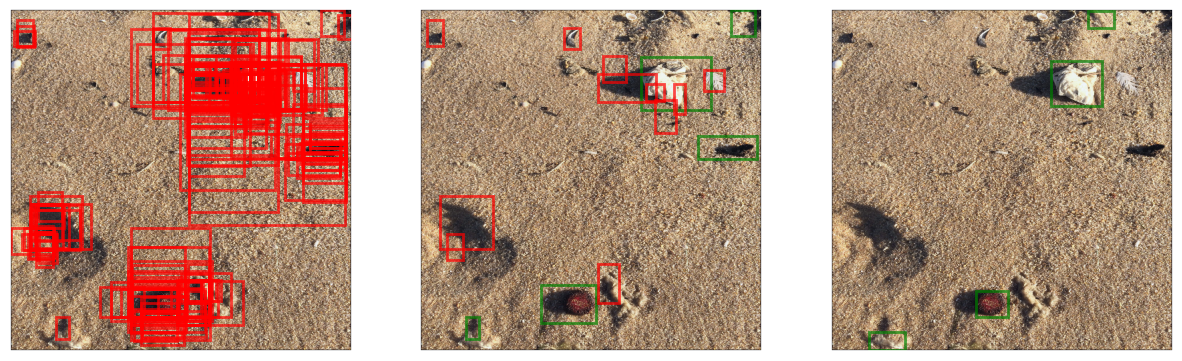

In [47]:
fig,ax = plt.subplots(1,3, figsize = (15,10))
img = test_images.detach().cpu()

img = denormalize(img)

for i in range(3):
    ax[i].imshow(img.detach().cpu().permute(1,2,0))
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Show annotations before NMS
for i, ann in enumerate(bboxes_xywh.cpu().numpy()):
    
    [x, y, x1, y1] = ann
    edge_col = 'red'
    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor=edge_col,
                     facecolor='none', alpha=0.7)
    ax[0].add_patch(rect)
# Show annotations after NMS
for i, ann in enumerate(final_bboxes.cpu().numpy()):
    
    [x, y, x1, y1] = ann
    if predictions_all[i]:
        edge_col = 'red'
    else:
        edge_col = 'green'
    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor=edge_col,
                     facecolor='none', alpha=0.7)
    ax[1].add_patch(rect)
for i, ann in enumerate(test_bboxes):
    
    [x, y, x1, y1] = ann
    
    edge_col = 'green'

    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor=edge_col,
                     facecolor='none', alpha=0.7)
    ax[2].add_patch(rect)
plt.savefig(f'imgs/output_{"comparison"}.png')
test_proposals_all
plt.show()

In [10]:
# images = [image for image, _, _ in batch]
# bboxes = [bbox for _, bbox, _ in batch]
# labels = [label for _, _, label in batch]

In [11]:
# k = 3

cropped_images_all, proposals_all, predictions_all = edge_boxes_train([images[k]], [bboxes[k]])       
img = images[k]##.cpu().numpy()

# #plt.imshow()

In [12]:
# def denormalize(img):
#     mean=[0.485, 0.456, 0.406]
#     std=[0.229, 0.224, 0.225]
    
#     denormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
#                          std=[1/0.229, 1/0.224, 1/0.225])

#     denorm_image = denormalize(img)
#     x = ((denorm_image - denorm_image.min())/(denorm_image - denorm_image.min()).max() * 255).to(torch.int64)
#     return x